In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tqdm import tqdm
import logging
from datetime import datetime


In [8]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [9]:
# Load the CIFAR-10 dataset
logger.info("Loading CIFAR-10 dataset...")
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

INFO:__main__:Loading CIFAR-10 dataset...


In [10]:
# # Use a smaller subset for initial testing
# SUBSET_SIZE = 5000  # Adjust this value as needed
# logger.info(f"Using subset of {SUBSET_SIZE} samples for testing")
# X_train = X_train[:SUBSET_SIZE]
# y_train = y_train[:SUBSET_SIZE]

In [11]:
# Reshape and scale the data
logger.info("Preprocessing data...")
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.flatten()
y_test = y_test.flatten()

INFO:__main__:Preprocessing data...


In [12]:
# Full Hyperparameter Search Spaces
rf_param_grid = {
    "n_estimators": Integer(50, 500),
    "criterion": Categorical(["gini", "entropy"]),
    "max_depth": Categorical([None, 3, 5, 10, 20, 30]),
    "min_samples_leaf": Integer(1, 16),
    "max_features": Categorical(["sqrt", "log2", 0.25, 0.5]),
    "bootstrap": Categorical([True, False]),
    "min_samples_split": Integer(2, 10),
    "class_weight": Categorical([None, "balanced", "balanced_subsample"]),
}

svm_param_grid = {
    "C": Real(1e-4, 1e3, "log-uniform"),
    "kernel": Categorical(["linear", "rbf", "poly", "sigmoid"]),
    "gamma": Categorical(["scale", "auto"] + [0.001, 0.01, 0.1, 1, 10]),
    "degree": Integer(2, 4),
    "coef0": Real(0.0, 1.0),
    "class_weight": Categorical([None, "balanced"]),
}

ensemble_param_grid = {
    "voting": Categorical(["soft", "hard"]),
    "weights": Categorical([None, (0.5, 0.5), (0.3, 0.7), (0.7, 0.3)]),
    "rf__n_estimators": Integer(100, 300),
    "rf__max_depth": Categorical([None, 10, 20]),
    "svm__C": Real(0.1, 10, "log-uniform"),
    "svm__gamma": Categorical(["scale", "auto", 0.01]),
}

# # Reduced Testing Version
# rf_param_grid = {
#     "n_estimators": Integer(50, 100),
#     "max_depth": Categorical([10, 20]),
#     "min_samples_split": Integer(2, 5),
#     "max_features": Categorical(["sqrt"]),
# }

# svm_param_grid = {
#     "C": Real(0.1, 1.0, "log-uniform"),  
#     "kernel": Categorical(["rbf"]),       
#     "gamma": Categorical(["scale"]),      
# }

# ensemble_param_grid = {
#     "voting": Categorical(["soft"]),              
#     "weights": Categorical([None]),                
#     "rf__n_estimators": Integer(50, 100),        
#     "rf__max_depth": Categorical([10]),          
#     "svm__C": Real(0.1, 0.5, "log-uniform"),     
#     "svm__gamma": Categorical(["scale"]),         
# }

In [13]:
class TqdmBayesSearchCV(BayesSearchCV):
    def _run_search(self, evaluate_candidates):
        with tqdm(total=self.n_iter, desc="Bayesian optimization") as pbar:
            def wrapped_evaluate(candidate_params):
                start_time = datetime.now()
                logger.info(f"Testing parameters: {candidate_params}")
                result = evaluate_candidates(candidate_params)
                end_time = datetime.now()
                duration = (end_time - start_time).total_seconds()
                logger.info(f"Iteration completed in {duration:.2f} seconds")
                pbar.update(1)
                return result
            return super()._run_search(wrapped_evaluate)

In [ ]:
# Tune Random Forest
rf = RandomForestClassifier(random_state=42)
bayes_search_rf = BayesSearchCV(estimator=rf, search_spaces=rf_param_grid, cv=3, n_jobs=-1, random_state=42, verbose=3)

# # Tune Random Forest with minimal iterations and verbose logging
# rf = RandomForestClassifier(random_state=42, verbose=1)
# bayes_search_rf = TqdmBayesSearchCV(
#     estimator=rf,
#     search_spaces=rf_param_grid,
#     cv=2,
#     n_jobs=-1,
#     random_state=42,
#     n_iter=3,
#     verbose=3,
# )

bayes_search_rf.fit(X_train_scaled, y_train)
print("Best Random Forest (BayesSearch) Hyperparameters:", bayes_search_rf.best_params_)

INFO:__main__:Starting Random Forest optimization...
Bayesian optimization:   0%|          | 0/3 [00:00<?, ?it/s]INFO:__main__:Testing parameters: [OrderedDict([('bootstrap', True), ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), ('max_depth', 3), ('max_features', 0.25), ('min_samples_leaf', 7), ('min_samples_split', 5), ('n_estimators', 383)])]


Fitting 2 folds for each of 1 candidates, totalling 2 fits


Bayesian optimization:   0%|          | 0/3 [00:59<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Tune SVM 
svm = SVC(probability=True, random_state=42)
bayes_search_svm = TqdmBayesSearchCV(estimator=svm, search_spaces=svm_param_grid, cv=3, n_jobs=-1, random_state=42, verbose=3)

# # Tune SVM (Reduced iterations and folds for testing)
# svm = SVC(probability=True, random_state=42)
# bayes_search_svm = TqdmBayesSearchCV(estimator=svm, search_spaces=svm_param_grid, cv=2, n_jobs=-1, random_state=42, n_iter=3, verbose=3)

bayes_search_svm.fit(X_train_scaled, y_train)
print("Best SVM (BayesSearch) Hyperparameters:", bayes_search_svm.best_params_)


Bayesian optimization:   0%|          | 0/3 [00:00<?, ?it/s]INFO:__main__:Testing parameters: [OrderedDict([('C', 0.25710111426089055), ('gamma', 'scale'), ('kernel', 'rbf')])]


Fitting 2 folds for each of 1 candidates, totalling 2 fits


INFO:__main__:Iteration completed in 134.08 seconds
Bayesian optimization:  33%|███▎      | 1/3 [02:14<04:28, 134.10s/it]INFO:__main__:Testing parameters: [OrderedDict([('C', 0.6876831063110332), ('gamma', 'scale'), ('kernel', 'rbf')])]


[CV 1/2] END C=0.25710111426089055, gamma=scale, kernel=rbf;, score=0.379 total time= 2.2min
[CV 2/2] END C=0.25710111426089055, gamma=scale, kernel=rbf;, score=0.353 total time= 2.2min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END C=0.6876831063110332, gamma=scale, kernel=rbf;, score=0.399 total time= 1.8min


INFO:__main__:Iteration completed in 110.50 seconds
Bayesian optimization:  67%|██████▋   | 2/3 [04:04<02:00, 120.22s/it]INFO:__main__:Testing parameters: [OrderedDict([('C', 0.278504689512848), ('gamma', 'scale'), ('kernel', 'rbf')])]


[CV 1/2] END C=0.6876831063110332, gamma=scale, kernel=rbf;, score=0.410 total time= 1.8min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END C=0.278504689512848, gamma=scale, kernel=rbf;, score=0.382 total time= 1.8min


INFO:__main__:Iteration completed in 108.10 seconds
Bayesian optimization: 100%|██████████| 3/3 [05:52<00:00, 117.57s/it]

[CV 2/2] END C=0.278504689512848, gamma=scale, kernel=rbf;, score=0.356 total time= 1.8min


Best SVM (BayesSearch) Hyperparameters: OrderedDict([('C', 0.6876831063110332), ('gamma', 'scale'), ('kernel', 'rbf')])


In [ ]:
# Create base models with best individual parameters
best_rf = RandomForestClassifier(**bayes_search_rf.best_params_, random_state=42)
best_svm = SVC(**bayes_search_svm.best_params_, probability=True, random_state=42)

In [ ]:
# Create and configure the VotingClassifier
ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('svm', best_svm)],
    voting='soft'
)

In [ ]:
# Tuning Ensemble
bayes_search_ensemble = TqdmBayesSearchCV(estimator=ensemble, search_spaces=ensemble_param_grid, cv=3, n_jobs=-1, random_state=42, verbose=3)


# # Tuning Ensemble (Reduced iterations and folds for testing)
# bayes_search_ensemble = TqdmBayesSearchCV(estimator=ensemble, search_spaces=ensemble_param_grid, cv=2, n_jobs=-1, random_state=42, n_iter=3, verbose=3)

bayes_search_ensemble.fit(X_train_scaled, y_train)
print("Best Ensemble (BayesSearch) Hyperparameters:", bayes_search_ensemble.best_params_) 

Bayesian optimization:   0%|          | 0/3 [00:00<?, ?it/s]INFO:__main__:Testing parameters: [OrderedDict([('rf__max_depth', 10), ('rf__n_estimators', 86), ('svm__C', 0.44879369728637786), ('svm__gamma', 'scale'), ('voting', 'soft'), ('weights', None)])]


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END rf__max_depth=10, rf__n_estimators=86, svm__C=0.44879369728637786, svm__gamma=scale, voting=soft, weights=None;, score=0.390 total time= 2.1min


INFO:__main__:Iteration completed in 133.40 seconds
Bayesian optimization:  33%|███▎      | 1/3 [02:13<04:26, 133.42s/it]INFO:__main__:Testing parameters: [OrderedDict([('rf__max_depth', 10), ('rf__n_estimators', 94), ('svm__C', 0.1629575797251231), ('svm__gamma', 'scale'), ('voting', 'soft'), ('weights', None)])]


[CV 1/2] END rf__max_depth=10, rf__n_estimators=86, svm__C=0.44879369728637786, svm__gamma=scale, voting=soft, weights=None;, score=0.406 total time= 2.2min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END rf__max_depth=10, rf__n_estimators=94, svm__C=0.1629575797251231, svm__gamma=scale, voting=soft, weights=None;, score=0.364 total time= 2.1min


INFO:__main__:Iteration completed in 128.96 seconds
Bayesian optimization:  67%|██████▋   | 2/3 [04:22<02:10, 130.80s/it]INFO:__main__:Testing parameters: [OrderedDict([('rf__max_depth', 10), ('rf__n_estimators', 96), ('svm__C', 0.11838410809003441), ('svm__gamma', 'scale'), ('voting', 'soft'), ('weights', None)])]


[CV 1/2] END rf__max_depth=10, rf__n_estimators=94, svm__C=0.1629575797251231, svm__gamma=scale, voting=soft, weights=None;, score=0.384 total time= 2.1min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END rf__max_depth=10, rf__n_estimators=96, svm__C=0.11838410809003441, svm__gamma=scale, voting=soft, weights=None;, score=0.360 total time= 2.2min


INFO:__main__:Iteration completed in 131.84 seconds
Bayesian optimization: 100%|██████████| 3/3 [06:34<00:00, 131.41s/it]

[CV 1/2] END rf__max_depth=10, rf__n_estimators=96, svm__C=0.11838410809003441, svm__gamma=scale, voting=soft, weights=None;, score=0.378 total time= 2.2min


Best Ensemble (BayesSearch) Hyperparameters: OrderedDict([('rf__max_depth', 10), ('rf__n_estimators', 86), ('svm__C', 0.44879369728637786), ('svm__gamma', 'scale'), ('voting', 'soft'), ('weights', None)])


In [ ]:
# --- Evaluation ---
def evaluate_model(model, X_test, y_test):
    y_test_bin = LabelBinarizer().fit_transform(y_test)
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(f"Accuracy: {accuracy:.4f}")

    y_score = model.predict_proba(X_test)
    plot_roc_curve(y_test_bin, y_score)
    plot_confusion_matrix(y_test, pred)


def plot_roc_curve(y_test_bin, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label="Class {} (AUC = {:.2f})".format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(y_test, pred):
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=range(10),
        yticklabels=range(10),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


--- Random Forest (Best from BayesSearch) ---


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


Accuracy: 0.3943


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


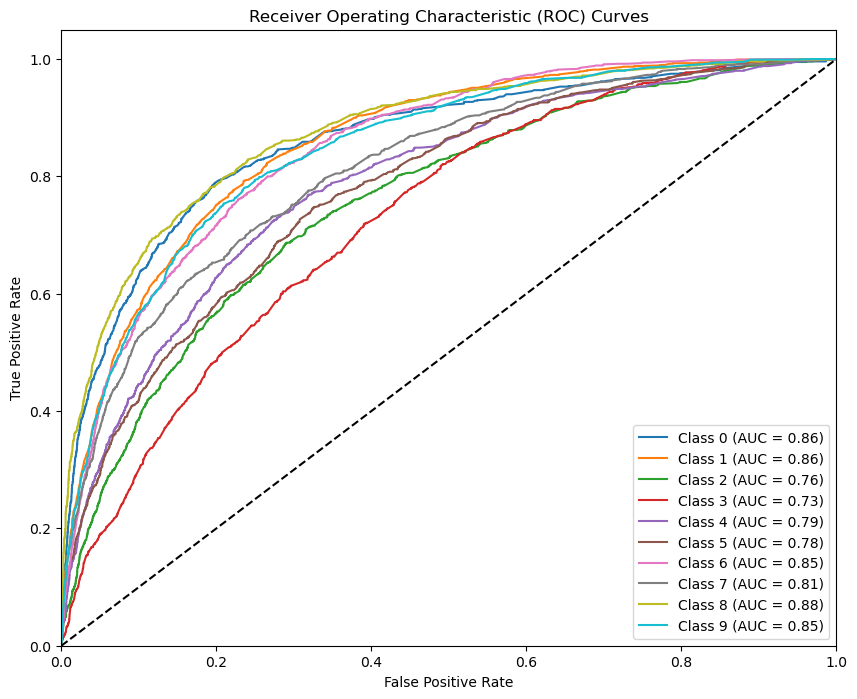

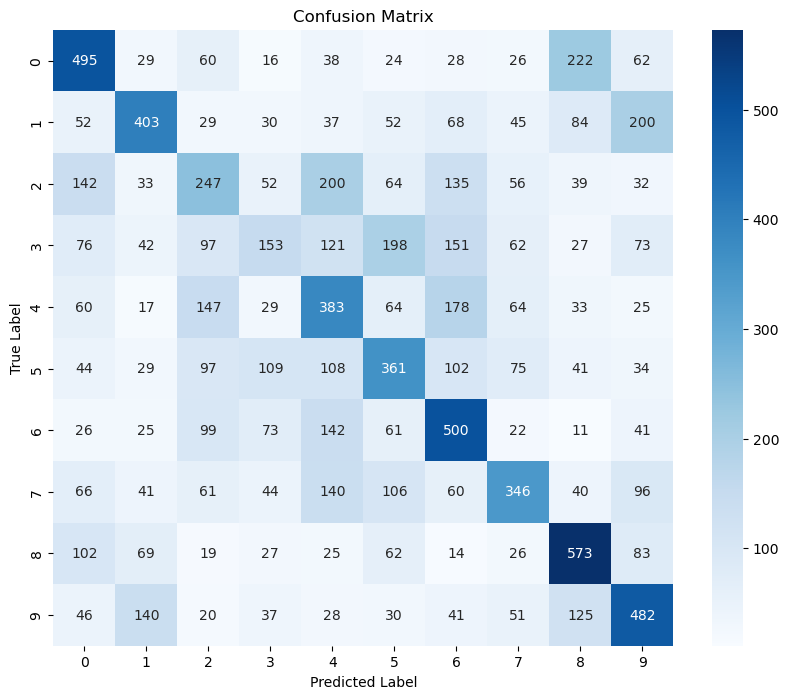

In [ ]:
print("\n--- Random Forest (Best from BayesSearch) ---")
evaluate_model(bayes_search_rf.best_estimator_, X_test_scaled, y_test)


--- SVM (Best from BayesSearch) ---
Accuracy: 0.4299


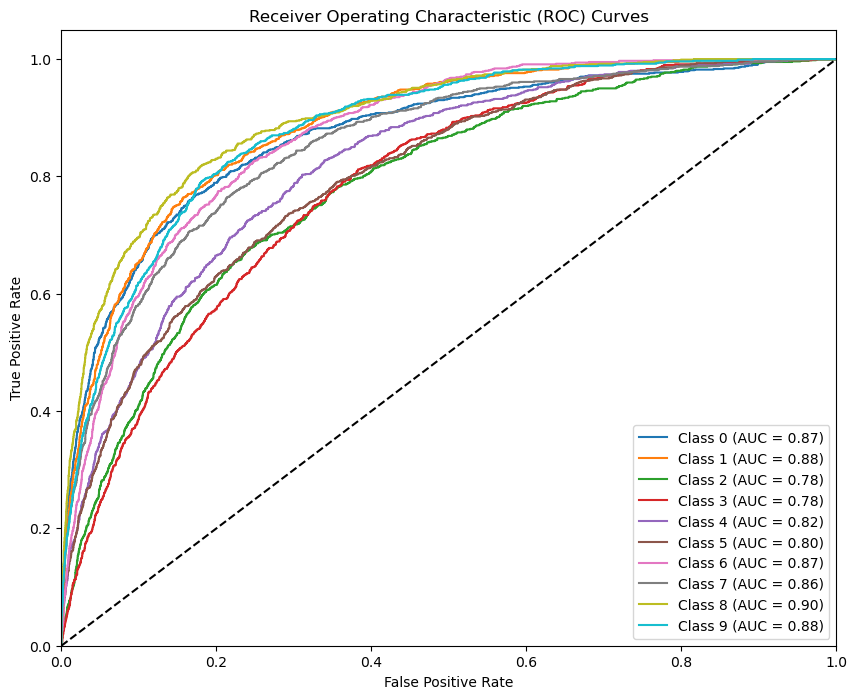

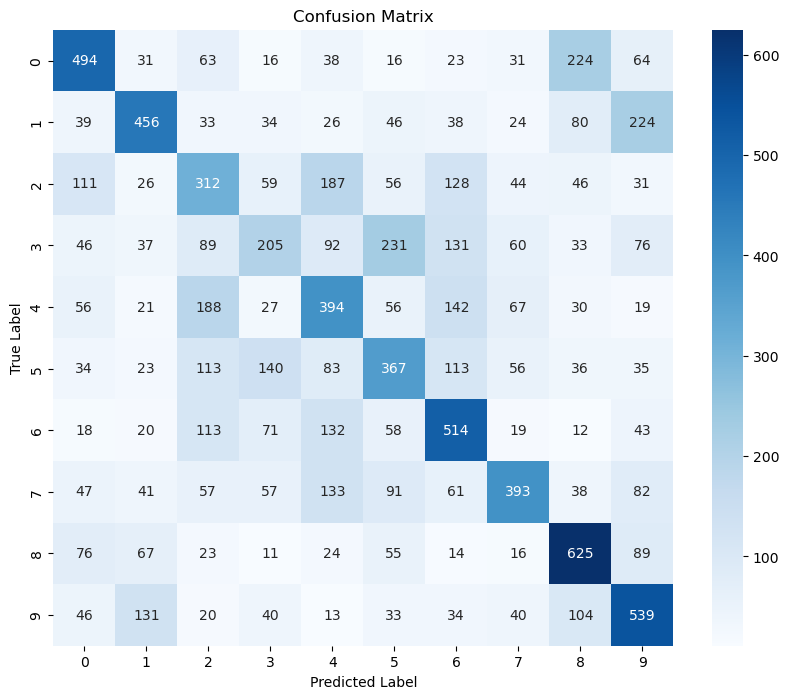

In [ ]:
print("\n--- SVM (Best from BayesSearch) ---")
evaluate_model(bayes_search_svm.best_estimator_, X_test_scaled, y_test)


--- Ensemble Model (Best from BayesSearch) ---
Accuracy: 0.4150


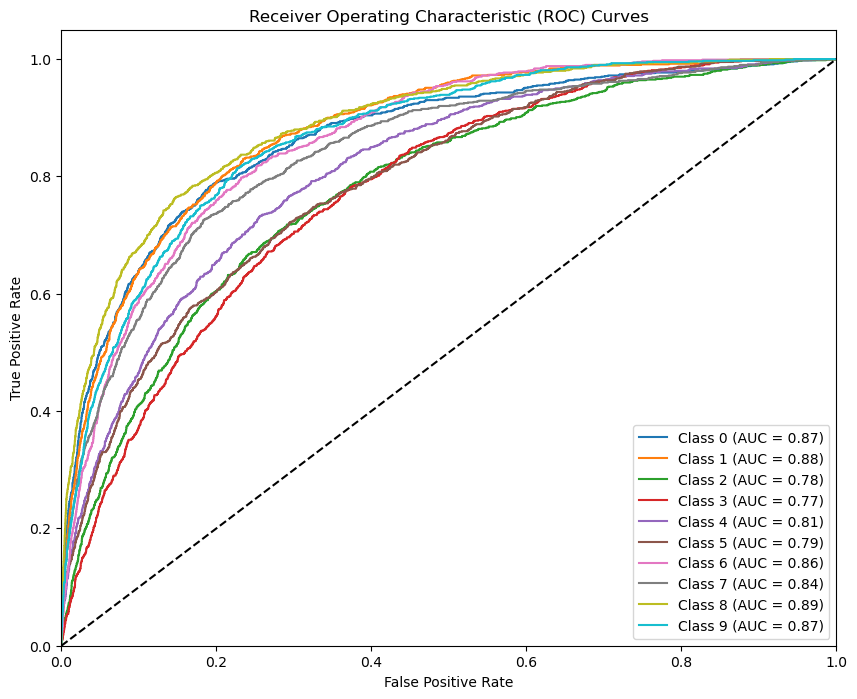

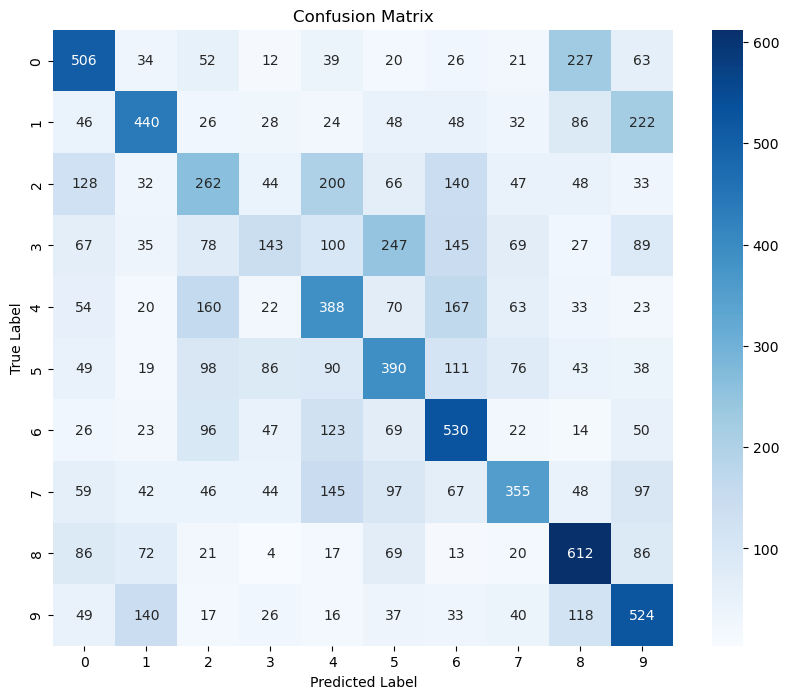

In [ ]:
print("\n--- Ensemble Model (Best from BayesSearch) ---")
evaluate_model(bayes_search_ensemble.best_estimator_, X_test_scaled, y_test)